In [1]:
# pip install arff pandas numpy spacy seaborn matplotlib sklearn openpyxl
# python3 -m spacy download pt_core_news_sm

In [2]:
# Fazendo imports
import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.lang.pt import Portuguese

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

2022-06-30 22:49:15.700616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 22:49:15.700633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
### Criando dataset de treino e de teste ###
dataset_number = 1

# Lacafe
# text = 'txt'
# label = 'has_anger'
# train_data = pd.read_csv(f'./Datasets/Lacafe/df_dataset_train_{dataset_number}.csv')
# test_data = pd.read_csv(f'./Datasets/Lacafe/df_dataset_test_{dataset_number}.csv')

# Fortuna
# text = 'text'
# label = 'hatespeech_comb'
# train_data = pd.read_csv(f'./Datasets/Fortuna/2019-05-28_portuguese_hate_speech_binary_classification_train_{dataset_number}.csv')
# test_data = pd.read_csv(f'./Datasets/Fortuna/2019-05-28_portuguese_hate_speech_binary_classification_test_{dataset_number}.csv')

# Fortuna (Updated)
# text = 'text'
# label = 'hatespeech_comb'
# train_data = pd.read_csv(f'./Datasets/FortunaUpdated/2019-05-28_portuguese_hate_speech_binary_classification_train_{dataset_number}.csv')
# test_data = pd.read_csv(f'./Datasets/FortunaUpdated/2019-05-28_portuguese_hate_speech_binary_classification_test_{dataset_number}.csv')

# ToLD-BR
# text = 'text'
# label = 'hatespeech'
# train_data = pd.read_csv(f'./Datasets/ToldBR/ToLD-BR-Treated_train_{dataset_number}.csv')
# test_data = pd.read_csv(f'./Datasets/ToldBR/ToLD-BR-Treated_test_{dataset_number}.csv')

# ToLD-BR (Updated)
text = 'text'
label = 'hatespeech'
train_data = pd.read_csv(f'./Datasets/ToldBRUpdated/ToLD-BR-Treated_train_{dataset_number}.csv')
test_data = pd.read_csv(f'./Datasets/ToldBRUpdated/ToLD-BR-Treated_test_{dataset_number}.csv')

# OffComBr
# text = 'text'
# label = 'offensive'
# train_data = pd.read_csv(f'./Datasets/OffComBR/OffComBR2_train_{dataset_number}.csv')
# test_data = pd.read_csv(f'./Datasets/OffComBR/OffComBR2_test_{dataset_number}.csv')

# HateBR
# text = 'instagram_comments'
# label = 'offensive_language'
# train_data = pd.read_csv(f'./Datasets/HateBR/HateBR_train_{dataset_number}.csv')
# test_data = pd.read_csv(f'./Datasets/HateBR/HateBR_test_{dataset_number}.csv')

In [4]:
# Word tokenization
import spacy
import string

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('pt_core_news_sm')
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_tokenizer(sentence, lemmatize=False, remove_stop_words=False, remove_punctuations=False):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lematizando os tokens e colocando em caixa baixa
    if (lemmatize):
        mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    else:
        mytokens = [ word.text.lower().strip() for word in mytokens ]

    # Removendo stop words
    if (remove_stop_words):
        mytokens = [ word for word in mytokens if word not in stop_words ]        
        
    if (remove_punctuations):
        mytokens = [ word for word in mytokens if word not in punctuations ]
        
    # Retornando a lista de token reprocessado
    return mytokens

text_pipeline = lambda x: spacy_tokenizer(x, lemmatize=True, remove_stop_words=True)
label_pipeline = lambda x: int(x)

In [5]:
# Tokenizando, transformando para lemas e botando em caixa baixa cada tweet
train_data[text] = [text_pipeline(str(txt)) for txt in train_data[text]]
test_data[text] = [text_pipeline(str(txt)) for txt in test_data[text]]

train_data.head()

,text,hatespeech_comb
0,"[', trocar, parabém, respeitar, ano, inteirar,...",0
1,"[lembrar, q, mttttt, tmp, atro, ,, achar, q, 7...",1
2,"[@fcmorango, umar, fuçada, ,, livrar, amigo, @...",0
3,"[queres, ', overdose, tourette, ', casino, fig...",0
4,"[rt, @brupls, :, fude, caro, querer, retratar,...",1


In [6]:
# Juntando os tokens de volta em um única string
# data[text] = data.apply(lambda x: " ".join(x[text]), axis=1)
train_data[text] = train_data.apply(lambda x: " ".join(x[text]), axis=1)
test_data[text] = test_data.apply(lambda x: " ".join(x[text]), axis=1)

train_data.head()

,text,hatespeech_comb
0,' trocar parabém respeitar ano inteirar ' par...,0
1,"lembrar q mttttt tmp atro , achar q 7 ano umar...",1
2,"@fcmorango umar fuçada , livrar amigo @melaine...",0
3,queres ' overdose tourette ' casino figueira p...,0
4,rt @brupls : fude caro querer retratar jesus r...,1


In [7]:
# Separando o treino e o teste em dois conjuntos diferentes
x_train = train_data[text]
y_train = train_data[label]
x_test = test_data[text]
y_test = test_data[label]

In [8]:
# convertendo em BOW com valoração de frequência
freq_vector = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(train_data[text])

x_train = freq_vector.transform(x_train)
x_test = freq_vector.transform(x_test)

In [9]:
x_train.shape

(3968, 1408)

In [10]:
x_test.shape

(1702, 1408)

In [11]:
# Logistic Regression Classifier sem Cross Validation
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=500)

# model generation
classifier.fit(x_train, y_train)

LogisticRegression(max_iter=500)

In [12]:
# Resultados do dataset de treino

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

y_pred_train = classifier.predict(x_train)
metrics = precision_recall_fscore_support(y_train, y_pred_train, average='macro')
accuracy = accuracy_score(y_train, y_pred_train)

print('---- Dataset de treino ----')
print(f'Accuracy: {str(accuracy * 100).replace(".", ",")}%')
print(f'Precision: {str(metrics[0] * 100).replace(".", ",")}%')
print(f'Recall: {str(metrics[1] * 100).replace(".", ",")}%')
print(f'Fscore: {str(metrics[2] * 100).replace(".", ",")}%')

---- Dataset de treino ----
Accuracy: 85,15625%
Precision: 85,36106460595579%
Recall: 79,30546251258103%
Fscore: 81,35847443912158%


In [13]:
# Resultados do dataset de teste

y_pred = classifier.predict(x_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print('---- Dataset de teste ----')
print(f'Accuracy: {str(accuracy * 100).replace(".", ",")}%')
print(f'Precision: {str(metrics[0] * 100).replace(".", ",")}%')
print(f'Recall: {str(metrics[1] * 100).replace(".", ",")}%')
print(f'Fscore: {str(metrics[2] * 100).replace(".", ",")}%')

---- Dataset de teste ----
Accuracy: 73,20799059929494%
Precision: 68,71835833111459%
Recall: 65,17099447734593%
Fscore: 66,08500946511194%


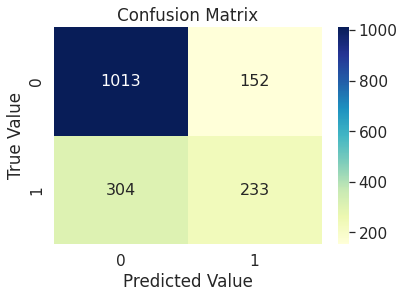

In [14]:
# Plotando matriz de confusão de teste

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

def plot_cm(conf_matrix):
  sns.set(font_scale=1.4,color_codes=True,palette="deep")
  sns.heatmap(cm,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")

plot_cm(cm)

In [15]:
# TESTE
x_try = freq_vector.transform([''])

print("x: ", x_try)

y_try = classifier.predict(x_try)

print("y: ", y_try)

precision_recall_fscore_support(y_try, [1.0], average='macro')

x:  
y:  [0]


/home/arthurn/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, None)